In [39]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [40]:
dataset = 'model/keypoint_classifier_jt/keypoint.csv'
model_save_path = 'model/keypoint_classifier_jt/keypoint_classifier.hdf5'

# 分類数設定

In [41]:
NUM_CLASSES = 6

# 学習データ読み込み

In [42]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [43]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [45]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [46]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [47]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=60, verbose=1)

In [48]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [49]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
38/43 [=========================>....] - ETA: 0s - loss: 1.7911 - accuracy: 0.1992
Epoch 1: saving model to model/keypoint_classifier_jt/keypoint_classifier.hdf5
43/43 [==============================] - 1s 9ms/step - loss: 1.7866 - accuracy: 0.2018 - val_loss: 1.7028 - val_accuracy: 0.2927
Epoch 2/1000
34/43 [======================>.......] - ETA: 0s - loss: 1.7130 - accuracy: 0.2571
Epoch 2: saving model to model/keypoint_classifier_jt/keypoint_classifier.hdf5
43/43 [==============================] - 0s 7ms/step - loss: 1.7027 - accuracy: 0.2659 - val_loss: 1.6025 - val_accuracy: 0.3711
Epoch 3/1000
42/43 [============================>.] - ETA: 0s - loss: 1.6150 - accuracy: 0.3242
Epoch 3: saving model to model/keypoint_classifier_jt/keypoint_classifier.hdf5
43/43 [==============================] - 0s 7ms/step - loss: 1.6133 - accuracy: 0.3260 - val_loss: 1.4775 - val_accuracy: 0.4936
Epoch 4/1000
40/43 [==========================>...] - ETA: 0s - loss: 1.5131 - accuracy:

In [50]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

15/15 [==============================] - 0s 2ms/step - loss: 0.5594 - accuracy: 0.8470


In [51]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [52]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[0.12761325 0.11342245 0.66985494 0.06722513 0.02045718 0.00142702]
2


In [53]:
# !pip install pandas seaborn matplotlib

# 混同行列

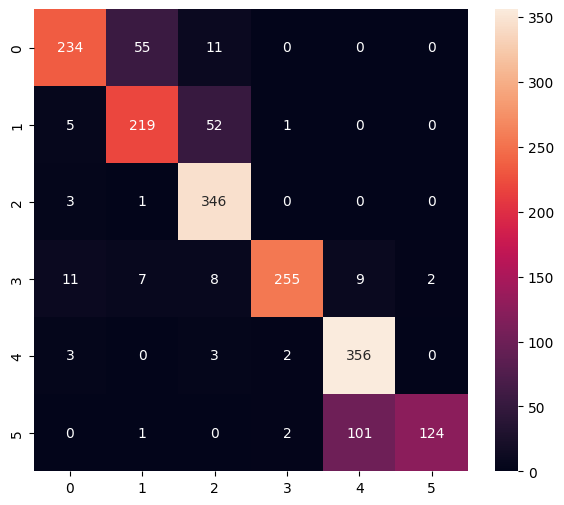

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       300
           1       0.77      0.79      0.78       277
           2       0.82      0.99      0.90       350
           3       0.98      0.87      0.92       292
           4       0.76      0.98      0.86       364
           5       0.98      0.54      0.70       228

    accuracy                           0.85      1811
   macro avg       0.87      0.83      0.83      1811
weighted avg       0.86      0.85      0.84      1811



In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [58]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [59]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier_jt/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2024-12-09 22:06:25.684876: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp0a6rq8zz/assets


2024-12-09 22:06:26.320109: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2024-12-09 22:06:26.320145: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


6392

# 推論テスト

In [60]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [61]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [62]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [63]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 925 µs, sys: 0 ns, total: 925 µs
Wall time: 848 µs


In [64]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.12761335 0.11342248 0.66985494 0.06722514 0.02045718 0.00142702]
2
